# FYS375 Modellering av solfanger
Gruppe 3 - Høst 2021

Modellering av solfanger. Her lages en model basert på data fra mars til juli 2020. Med gjeldene krav fra ASHRAE-93.  
De predikerte verdiene er plottet mot målte verdier, og samlignet med en benchmarkmodell med 50% virkningsgrad.  
Nøkkeltall:  
Datapunkter i 2020: 586  
$RMSE_{model} = 16.206$  
$RMSE_{benchmark} = 28.095$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("Måledata_mars_juli_2020.csv")
data.Time = pd.to_datetime(data.Time)
data

,Time,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
0,2020-03-01 00:01:00,0.0,0.4,15.6,107.0,23.6
1,2020-03-01 00:02:00,0.0,0.4,15.6,107.0,23.6
2,2020-03-01 00:03:00,0.0,0.4,15.6,107.0,23.6
3,2020-03-01 00:04:00,0.0,0.4,15.6,107.0,23.6
4,2020-03-01 00:05:00,0.0,0.4,15.6,107.0,23.6
...,...,...,...,...,...,...
220314,2020-07-31 23:55:00,-1.0,17.7,25.5,0.0,26.9
220315,2020-07-31 23:56:00,-1.0,17.8,25.5,0.0,26.9
220316,2020-07-31 23:57:00,-1.0,17.8,25.5,0.0,26.9
220317,2020-07-31 23:58:00,-1.0,17.8,25.5,0.0,26.9


In [3]:
def find_irradiance(data):
    try:
        data_irra = data[data["Irradiance (W/m2)"] > 790]
    except:
        data_irra = data[data["Irradience (W/m2)"] > 790]
    return data_irra.to_numpy()

In [4]:
def find_15_min_intervall(np_data):
    info = []
    for i, (tid, irradiance, Ta, Ti, ms, To) in enumerate(np_data[15:]):
        if tid - np_data[i][0] == pd.Timedelta("15m"):
            # save all 15 minutes innside infomration
            info.append(np_data[i:i+15])
    info = np.array(info)
    return info

## Sette opp kravene våres til steady-state
$Irradiance \pm 32$  
$T_{a} \pm 1.5$  
$T_{i} \pm 1$  

In [5]:
def steady_state_krav(info):
    innenfor_krav = []

    for intervall15min in info:
        ir_mean, Ta_mean, Ti_mean, _, To_mean = (np.mean(intervall15min[:,1:], axis=0))
        if (np.max(abs(ir_mean - intervall15min[:,1])) <= 32 and 
            np.max(abs(Ta_mean - intervall15min[:,2])) <= 1.5 and 
            np.max(abs(To_mean - intervall15min[:,5])) <= 1 and
            np.min(intervall15min[:,4]) >= 50):

            innenfor_krav.append(intervall15min)
    innenfor_krav = np.array(innenfor_krav)
    return innenfor_krav

In [6]:
def delete_duplicates(innenfor_krav):
    femtenmin_split = np.array(innenfor_krav[0:2])

    for i,v in enumerate(innenfor_krav[2:]):
        print(f"{i} av {len(innenfor_krav[2:])}",end="\r")
        if not np.isin(v[:,0], femtenmin_split[:, :, 0]).any():
            #print("legger til")
            femtenmin_split = np.append(femtenmin_split, [v], axis=0)

    femtenmin_split = femtenmin_split[1:]
    return femtenmin_split

## Filtere massestrømmer: mean $\pm$ 1std
Beholder massestrømmen som er mest like ved å finne snittet og standardavviket.

In [7]:
def remove_ms_std(femtenmin_split):
    snitt = np.mean(femtenmin_split[:, :, 4].flatten())
    std = np.std(femtenmin_split[:, :, 4].flatten())

    femtenmin_split = femtenmin_split[(abs(femtenmin_split[:,:,4] - snitt) /std <= 1).any(axis=1)]
    print(f"snitt: {snitt:.2f}, std:{std:.2f}")
    return femtenmin_split

In [8]:
data_irra = find_irradiance(data)
info = find_15_min_intervall(data_irra)
innenfor_krav = steady_state_krav(info)
femtenmin_split = delete_duplicates(innenfor_krav)
ready_15_min_intervall = remove_ms_std(femtenmin_split)

snitt: 374.29, std:42.89


# Modellering

### Finne variabel (X) veridene for hvert momentanpunkt:   
(1) $\frac{T_i - T_a}{G_T}$  [Tm2/W]  

### Finne virkningsgrad ved å se max effekt og Q  
(2) $\eta = \frac{Q}{GA}$


### Effekt i vannet 
c = 4.183 j/g K  
(3) $Q = \dot{m} c \Delta T $ [W]

### Max effekt
Solfanger er A=67,2 m2  
(4) $GA = G * A $  [W]  



In [10]:
def formulas(femtenmin_split):
    X = []
    Q = []
    GA = []
    for i in femtenmin_split:
        ir_mean, Ta_mean, Ti_mean, m_s_mean, To_mean = np.mean(i[:, 1:], axis=0)

        # X formelen (1)
        x = (Ti_mean - Ta_mean)/ir_mean 
        X.append(x)

        # Q formelen (3)
        q = m_s_mean * 4.183 * (To_mean - Ti_mean)
        Q.append(q)

        # GA foremlen (4)
        ga = ir_mean * 67.2
        GA.append(ga)


    X = np.array(X)
    Q = np.array(Q)
    GA = np.array(GA)
    n = Q/GA # (2)
    return X, Q, GA, n

In [11]:
X, Q, GA, n = formulas(ready_15_min_intervall)

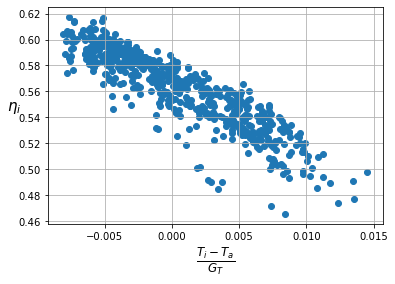

In [12]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.grid()
plt.xlabel("$\\frac{T_{i} - T_{a}}{G_{T}}$", fontsize=17)
plt.ylabel("$\eta_{i}$", fontsize=15).set_rotation(0)
plt.show()

In [13]:
reg = LinearRegression().fit(X[n>0.2].reshape(-1,1),n[n>0.2].reshape(-1,1))
print(f"r2score: {reg.score(X[n>0.2].reshape(-1,1),n[n>0.2].reshape(-1,1))}")

r2score: 0.7941282898548367


In [14]:
pred = reg.predict(X[n>0.2].reshape(-1,1))

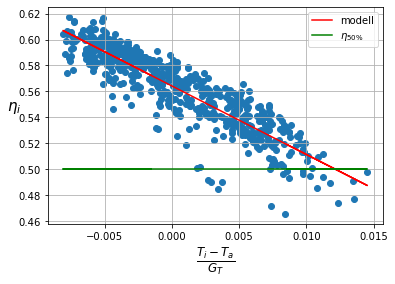

In [15]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.plot(X[n>0.2],pred, c="red", label="modell")
plt.plot(X[n>0.2],[0.5 for i in range(len(pred))], c="green", label="$\eta_{50\%}$")
plt.grid()
plt.xlabel("$\\frac{T_{i} - T_{a}}{G_{T}}$", fontsize=17)
plt.ylabel("$\eta_{i}$", fontsize=15).set_rotation(0)
plt.legend()
plt.show()

In [16]:
print(f"b_1: {reg.coef_}.. \t = Fr*Ul")
print(f"b0: {reg.intercept_}..\t = Fr(τα)")

Fr = reg.intercept_ / (0.85 * 0.95) 
print(f"Fr er {Fr}")

Ul  = -reg.coef_[0][0] / Fr
print(f"Ul er {Ul}")

b_1: [[-5.27614314]].. 	 = Fr*Ul
b0: [0.5642758]..	 = Fr(τα)
Fr er [0.69879356]
Ul er [7.55036028]


## Estimere energi for 2021

In [17]:
data = pd.read_csv("Måledata_mars_juli_2021.csv")
try:
    data = data.rename(columns={"Irradience (W/m2)":"Irradiance (W/m2)"})
except:
    print("Heter Irradiance (W/m2) allerede")

In [18]:
data.Time = pd.to_datetime(data.Time)
data.index = data.Time
data = data.drop(columns=["Time"])

### Energi målt
$Q = \dot{m} c \Delta T$

In [19]:
data["energi [kWh]"] = data["Mass flow (g/s)"] * 4.183 * (data["Outlet Temperature (C)"] - data["Inlet Temperature (C)"]) * (1/60) *1e-3

### Energi predikert

$\eta_{pred} = \frac{Q}{GA} = Fr * (\tau \alpha) - Fr * Ul \frac{T_i - T_a}{G} $  

$Q_{pred} = Fr *  (\tau \alpha) * GA - Fr * Ul (T_i - T_a) * A $

$\eta = \frac{Q}{GA} = \frac{\dot{m} c \Delta T}{GA}$

In [20]:
Fr = 0.69718706
Ul = 7.55036028
tau = 0.85
alpha = 0.95
areal = 67.2

data["pred Q [W]"] = Fr * (tau * alpha) * data["Irradiance (W/m2)"] * areal - Fr * Ul * (data["Inlet Temperature (C)"] -data["Ambient Temperature (C)"]) * areal
data["pred energi [kWh]"] = data["pred Q [W]"] * (1/60) * 1e-3
data["dårligmodell [kWh]"] = data['Irradiance (W/m2)'] * areal * 0.5 * (1/60) * 1e-3

Antar at alle predikerte verdier der Q blir mindre enn 0 ikke skjer i virkeligheten. Setter derfor alle negative verdier til 0

In [21]:
t = data["pred energi [kWh]"].to_numpy()
t[t < 0] = 0
data["pred energi [kWh]"] = t

In [22]:
# Samler det i dagsintervall og summerer opp energien
data_per_dag = data.resample("1D").sum()

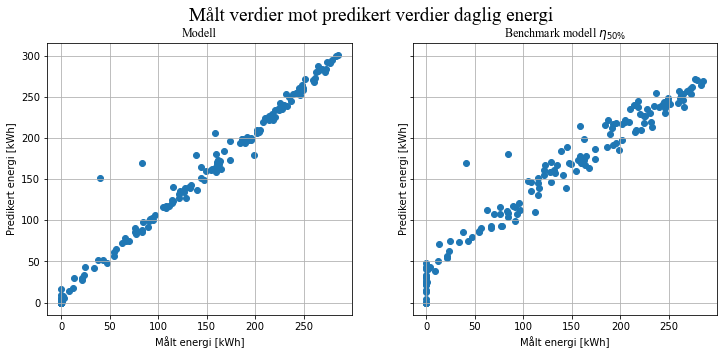

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(12,5))
ax1.scatter(data_per_dag["energi [kWh]"], data_per_dag["pred energi [kWh]"])
ax1.set_title("Modell", fontname="Times New Roman")
ax2.scatter(data_per_dag["energi [kWh]"], data_per_dag["dårligmodell [kWh]"])
ax2.set_title("Benchmark modell $\eta_{50\%}$", fontname="Times New Roman")
ax1.grid(); ax2.grid()

ax1.set_xlabel("Målt energi [kWh]"); ax2.set_xlabel("Målt energi [kWh]")
ax1.set_ylabel("Predikert energi [kWh]"); ax2.set_ylabel("Predikert energi [kWh]")
fig.suptitle("Målt verdier mot predikert verdier daglig energi", fontsize=19, fontname="Times New Roman")
plt.show()

In [24]:
print(f"RMSE for egen modell: {math.sqrt(mean_squared_error(data_per_dag['energi [kWh]'], data_per_dag['pred energi [kWh]'])):.3f}")
print(f"RMSE for benchmark modell: {math.sqrt(mean_squared_error(data_per_dag['energi [kWh]'], data_per_dag['dårligmodell [kWh]'])):.3f}")

RMSE for egen modell: 16.206
RMSE for benchmark modell: 28.095
